In [1]:
# Import modules
import datetime
import spiceypy
import numpy as np

# Load the SPICE kernels via a meta file
spiceypy.furnsh('kernel_meta.txt')

In [2]:
# We want to compute the Solar System barycentre (SSB) w.r.t to the centre of
# the Sun for a certain time interval
# First, we set an initial time in UTC.
INIT_TIME_UTC = datetime.datetime(year=2000, month=1, day=1, \
                                  hour=0, minute=0, second=0)

# Add a number of days; you can play around with the datetime variables; but
# leave it as it is for the first try, since other computations and comments
# are based on this value.
DELTA_DAYS = 10000
END_TIME_UTC = INIT_TIME_UTC + datetime.timedelta(days=DELTA_DAYS)

# Convert the datetime objects now to strings
INIT_TIME_UTC_STR = INIT_TIME_UTC.strftime('%Y-%m-%dT%H:%M:%S')
END_TIME_UTC_STR = END_TIME_UTC.strftime('%Y-%m-%dT%H:%M:%S')

# Print the starting and end times
print('Init time in UTC: %s' % INIT_TIME_UTC_STR)
print('End time in UTC: %s\n' % END_TIME_UTC_STR)

# Convert to Ephemeris Time (ET) using the SPICE function utc2et.
INIT_TIME_ET = spiceypy.utc2et(INIT_TIME_UTC_STR)
END_TIME_ET = spiceypy.utc2et(END_TIME_UTC_STR)

Init time in UTC: 2000-01-01T00:00:00
End time in UTC: 2027-05-19T00:00:00



In [3]:
# A day has 86400 seconds (24 hours * 60 minutes * 60 seconds)
# In our example, we set a time period of 10000 days. Thus, we expect the
# difference between INIT_TIME_ET and END_TIME_ET to be 10000*86400 seconds
# Let's have a look at the delta.
print('Covered time interval in seconds: %s\n' % (END_TIME_ET - INIT_TIME_ET))
# We see that 5.0012845 seconds are added in this time period (leap-seconds)

# Create a numpy array that covers a time interval in delta = 1 day step
TIME_INTERVAL_ET = np.linspace(INIT_TIME_ET, END_TIME_ET, DELTA_DAYS)

Covered time interval in seconds: 864000005.0012845



In [4]:
# Now we compute the position of the Solar System's barycentre w.r.t. our Sun:
# First we set an empty list that stores later all x, y, z components for each
# time step
SSB_WRT_SUN_POSITION = []

# Each time step is used in this for-loop to compute the position of the SSB
# w.r.t. the Sun. We use the function spkgps.
for TIME_INTERVAL_ET_f in TIME_INTERVAL_ET:
    _position, _ = spiceypy.spkgps(targ=0, et=TIME_INTERVAL_ET_f, \
                                   ref='ECLIPJ2000', obs=10)

    # Append the result to the final list
    SSB_WRT_SUN_POSITION.append(_position)

# Convert the list to a numpy array
SSB_WRT_SUN_POSITION = np.array(SSB_WRT_SUN_POSITION)

In [5]:
# Let's have a look at the first entry and ...
print('Position (components) of the Solar System Barycentre w.r.t the\n' \
      'centre of the Sun (at initial time): \n' \
      'X = %s km\n' \
      'Y = %s km\n' \
      'Z = %s km\n' % tuple(np.round(SSB_WRT_SUN_POSITION[0])))

# ... let's determine and print the corresponding distance using the numpy
# function linalg.norm()
print('Distance between the Solar System Barycentre w.r.t the\n' \
      'centre of the Sun (at initial time): \n' \
      'd = %s km\n' % round(np.linalg.norm(SSB_WRT_SUN_POSITION[0])))

Position (components) of the Solar System Barycentre w.r.t the
centre of the Sun (at initial time): 
X = 1068000.0 km
Y = 417681.0 km
Z = -30845.0 km

Distance between the Solar System Barycentre w.r.t the
centre of the Sun (at initial time): 
d = 1147185.0 km



In [6]:
# We want to visualise the results, to a get feeling of the movement. Is the
# movement somehow interesting and / or significant?

# Using km are not intuitive. AU would scale it to severly. Since we compute
# the SSB w.r.t the Sun; and since we expect it to be close to the Sun, we
# scale the x, y, z component w.r.t the radius of the Sun. We extract the
# Sun radii (x, y, z components of the Sun ellipsoid) and use the x component
_, RADII_SUN = spiceypy.bodvcd(bodyid=10, item='RADII', maxn=3)

RADIUS_SUN = RADII_SUN[0]

# Scale the position values using the Sun's radius
SSB_WRT_SUN_POSITION_SCALED = SSB_WRT_SUN_POSITION / RADIUS_SUN

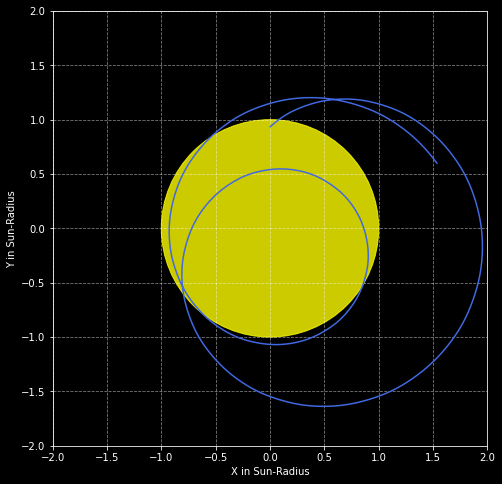

In [7]:
# We plot now the trajectory of the SSB w.r.t the Sun using matplotlib
from matplotlib import pyplot as plt

# We only plot the x, y components (view on the ecliptic plane)
SSB_WRT_SUN_POSITION_SCALED_XY = SSB_WRT_SUN_POSITION_SCALED[:, 0:2]

# Set a dark background... since... space is dark
plt.style.use('dark_background')

# Create a figure and ax.
FIG, AX = plt.subplots(figsize=(12, 8))

# Create a yellow circle that represents the Sun, add it to the ax
SUN_CIRC = plt.Circle((0.0, 0.0), 1.0, color='yellow', alpha=0.8)
AX.add_artist(SUN_CIRC)

# Plot the SSB movement
AX.plot(SSB_WRT_SUN_POSITION_SCALED_XY[:, 0], \
        SSB_WRT_SUN_POSITION_SCALED_XY[:, 1], \
        ls='solid', color='royalblue')

# Set some parameters for the plot, set an equal ratio, set a grid, and set
# the x and y limits
AX.set_aspect('equal')
AX.grid(True, linestyle='dashed', alpha=0.5)
AX.set_xlim(-2, 2)
AX.set_ylim(-2, 2)

# Some labelling
AX.set_xlabel('X in Sun-Radius')
AX.set_ylabel('Y in Sun-Radius')

# Saving the figure in high quality.
plt.savefig('SSB_WRT_SUN.png', dpi=300)

In [8]:
# How many days is the SSB outside the Sun? First, we compute the euclidean
# distance between the SSB and Sun.
SSB_WRT_SUN_DISTANCE_SCALED = np.linalg.norm(SSB_WRT_SUN_POSITION_SCALED, \
                                             axis=1)

print('Computation time: %s days\n' % DELTA_DAYS)

# Compute number of days outside the Sun
SSB_OUTSIDE_SUN_DELTA_DAYS = len(np.where(SSB_WRT_SUN_DISTANCE_SCALED > 1)[0])

print('Fraction of time where the SSB\n' \
      'was outside the Sun: %s %%' % (100 * SSB_OUTSIDE_SUN_DELTA_DAYS \
                                      / DELTA_DAYS))

Computation time: 10000 days

Fraction of time where the SSB
was outside the Sun: 64.64 %
